In [ ]:
# https://ieeexplore.ieee.org/document/10175491
#https://github.com/RasaHQ/rasa
#!pip install tensorflow
import keras
from tensorflow.keras.preprocessing.text import Tokenizer # Use tensorflow.keras
from tensorflow.keras.preprocessing.sequence import pad_sequences # Use tensorflow.keras
from tensorflow.keras.layers import Dropout # Import Dropout layer
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
# https://www.kaggle.com/datasets/nelgiriyewithana/mcdonalds-store-reviews
# Importando dataset
df = pd.read_csv('McDonald_s_Reviews.csv', encoding='latin-1') # Try 'latin-1' encoding
print(df.head())
print(df.describe())
print(df.info())
"""
df = df_total.head(100)
print(df.head())
print(df.describe())
print(df.info())
"""
# Preprocesamiento de las secuencias
review = []
sentences = list(df['review'])
for sen in sentences:
    review.append(sen)
#review[:5]
# Preprocesamiento de las secuencias

labels = df['rating']
# Preprocesamiento de las secuencias

label_encoder = LabelEncoder()
# Preprocesamiento de las secuencias
labels = label_encoder.fit_transform(labels)
# Preprocesamiento de las secuencias
labels = np.array(labels)
# Preprocesamiento de las secuencias
labels = labels.reshape(-1, 1)
# Preprocesamiento de las secuencias
labels = tf.keras.utils.to_categorical(labels, num_classes=5)
# Preprocesamiento de las secuencias
labels[:5]
# Preprocesamiento de las secuencias
from sklearn.model_selection import train_test_split
train_sentences, test_sentences, train_labels, test_labels = train_test_split(review, labels, test_size=0.20, random_state=42)

# Parametros
vocab_size = 50000
embedding_dim = 32
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# inicializar la clase tokenizer
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)

# Generar el diccionario de indices de palabras para el entrenamiento de las frases
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

# Generar y hacer pad a las secuencias entrenadas
sequences = tokenizer.texts_to_sequences(train_sentences)
padded = pad_sequences(sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type)
padded
# Generar y hacer pad a las secuencias de prueba
testing_sequences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type)

# Contruir el modelo
model = keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.LSTM(64, return_sequences=True),
    Dropout(0.2),
    keras.layers.LSTM(32),
    Dropout(0.2),
    keras.layers.Dense(6, activation='relu'),
    Dropout(0.2),
    keras.layers.Dense(5, activation='softmax')  # Change to 5 neurons with softmax
])

# Compilación del modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # Use categorical_crossentropy

# Imprimir el resumen del modelo
model.summary()

num_epochs = 10

# Entrenamiento del modelo
history = model.fit(padded, train_labels, epochs = num_epochs, validation_data = (testing_padded, test_labels))


# Graficar el historial de entrenamiento
pd.DataFrame(history.history).plot(grid=True)
plt.show()

# Genera predicciones para los datos de prueba
predictions = model.predict(testing_padded)
# Convierte las probabilidades en etiquetas (0 o 1)
predicted_labels = np.argmax(predictions, axis=1)

# NO NEED TO CONVERT predicted_labels to one-hot encoding
# predicted_labels_onehot = tf.keras.utils.to_categorical(predicted_labels, num_classes=5)

# Convert test_labels to class indices
test_labels_indices = np.argmax(test_labels, axis=1)

# Calcula la precisión del modelo
accuracy = np.mean(predicted_labels == test_labels_indices)  # Compare indices of predicted and true labels
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

# Revisar la distribución en un histograma
labels = df['rating'].tolist()
plt.figure(figsize=(4, 2))
plt.hist(labels, color='skyblue', edgecolor='black', rwidth=0.9, bins=5)  # rwidth controla el ancho de las barras
plt.xlabel('Sentiment')
plt.ylabel('Frecuency')
plt.title('Distribución de Etiquetas')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Convert test_labels to class indices
test_labels_indices = np.argmax(test_labels, axis=1)

# Use 'weighted' averaging for multiclass F1-score
f1 = f1_score(test_labels_indices, predicted_labels, average='weighted')  # Pass class indices for both true and predicted labels
print(f"F1-score: {f1}")

# Calculate confusion matrix using class indices for both true and predicted labels
cm = confusion_matrix(test_labels_indices, predicted_labels)  # Change here
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['1 star', '2 stars', '3 stars', '4 stars', '5 stars'])
disp.plot()
plt.show()

#sns.heatmap(cm, annot=True, fmt='d')
#plt.xlabel('Predicted')
#plt.ylabel('True')
#plt.show()

# Calculate probabilities for each class
y_pred_proba = model.predict(testing_padded)

# ROC curve for each class
plt.figure()
for i in range(y_pred_proba.shape[1]):  # Assuming one-hot encoded predictions
    fpr, tpr, _ = roc_curve(test_labels_indices == i, y_pred_proba[:, i]) # Use test_labels_indices which contains class indices
    auc = roc_auc_score(test_labels_indices == i, y_pred_proba[:, i]) # Use test_labels_indices which contains class indices
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, label='Class %d (AUC = %0.2f)' % (i, auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass')
plt.legend()
plt.show()


# Convert test_labels to class indices
test_labels_indices = np.argmax(test_labels, axis=1)

# Calculate errors using class indices
errors = predicted_labels - test_labels_indices

plt.hist(errors, bins=5)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Errors')
plt.show()

   reviewer_id  store_name              category  \
0            1  McDonald's  Fast food restaurant   
1            2  McDonald's  Fast food restaurant   
2            3  McDonald's  Fast food restaurant   
3            4  McDonald's  Fast food restaurant   
4            5  McDonald's  Fast food restaurant   

                                       store_address  latitude   longitude  \
0  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   
1  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   
2  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   
3  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   
4  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   

  rating_count   review_time  \
0        1,240  3 months ago   
1        1,240    5 days ago   
2        1,240    5 days ago   
3        1,240   a month ago   
4        1,240  2 months ago   

                         

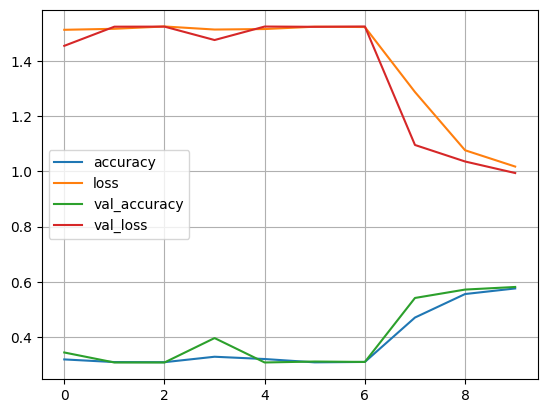

209/209 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step
Precisión del modelo: 58.08%


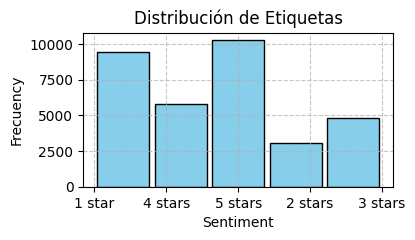

F1-score: 0.5008213610017445


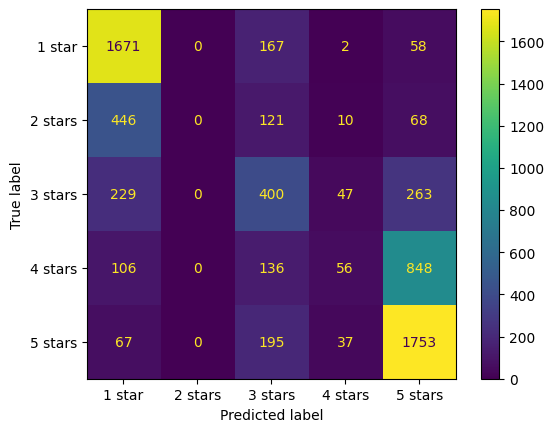

209/209 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step


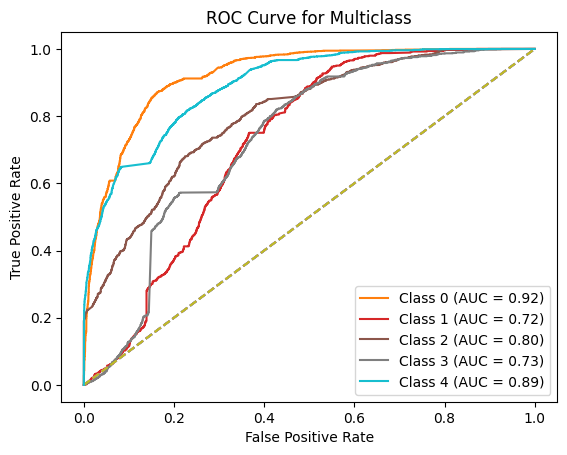

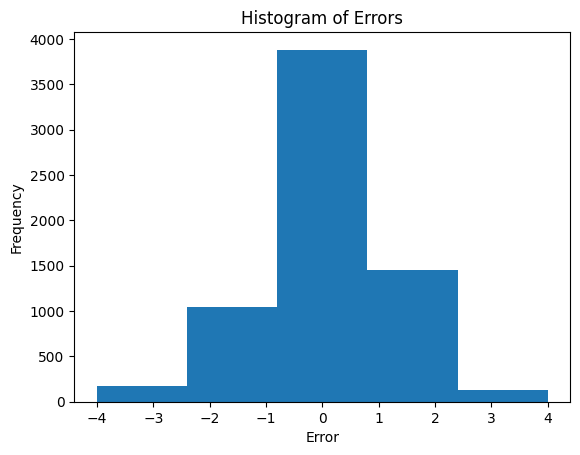

In [ ]:
# Contruir el modelo
model = keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.LSTM(64, return_sequences=True),
    Dropout(0.25),
    keras.layers.LSTM(32),
    Dropout(0.25),
    keras.layers.Dense(64, activation='relu'),
    Dropout(0.25),
    keras.layers.Dense(5, activation='sigmoid') # 5 neurons for 5 classes with softmax activation
])

# Compilación del modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # Use categorical_crossentropy for multi-class

# Imprimir el resumen del modelo
model.summary()

num_epochs = 10

# Entrenamiento del modelo
history = model.fit(padded, train_labels, epochs = num_epochs, validation_data = (testing_padded, test_labels))

# Graficar el historial de entrenamiento
pd.DataFrame(history.history).plot(grid=True)
plt.show()

# Genera predicciones para los datos de prueba
predictions = model.predict(testing_padded)
# Convierte las probabilidades en etiquetas (0 o 1)
predicted_labels = np.argmax(predictions, axis=1)

# NO NEED TO CONVERT predicted_labels to one-hot encoding
# predicted_labels_onehot = tf.keras.utils.to_categorical(predicted_labels, num_classes=5)

# Convert test_labels to class indices
test_labels_indices = np.argmax(test_labels, axis=1)

# Calcula la precisión del modelo
accuracy = np.mean(predicted_labels == test_labels_indices)  # Compare indices of predicted and true labels
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

# Revisar la distribución en un histograma
labels = df['rating'].tolist()
plt.figure(figsize=(4, 2))
plt.hist(labels, color='skyblue', edgecolor='black', rwidth=0.9, bins=5)  # rwidth controla el ancho de las barras
plt.xlabel('Sentiment')
plt.ylabel('Frecuency')
plt.title('Distribución de Etiquetas')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Convert test_labels to class indices
test_labels_indices = np.argmax(test_labels, axis=1)

# Use 'weighted' averaging for multiclass F1-score
f1 = f1_score(test_labels_indices, predicted_labels, average='weighted')  # Pass class indices for both true and predicted labels
print(f"F1-score: {f1}")

# Calculate confusion matrix using class indices for both true and predicted labels
cm = confusion_matrix(test_labels_indices, predicted_labels)  # Change here
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['1 star', '2 stars', '3 stars', '4 stars', '5 stars'])
disp.plot()
plt.show()

#sns.heatmap(cm, annot=True, fmt='d')
#plt.xlabel('Predicted')
#plt.ylabel('True')
#plt.show()

# Calculate probabilities for each class
y_pred_proba = model.predict(testing_padded)

# ROC curve for each class
plt.figure()
for i in range(y_pred_proba.shape[1]):  # Assuming one-hot encoded predictions
    fpr, tpr, _ = roc_curve(test_labels_indices == i, y_pred_proba[:, i]) # Use test_labels_indices which contains class indices
    auc = roc_auc_score(test_labels_indices == i, y_pred_proba[:, i]) # Use test_labels_indices which contains class indices
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, label='Class %d (AUC = %0.2f)' % (i, auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass')
plt.legend()
plt.show()


# Convert test_labels to class indices
test_labels_indices = np.argmax(test_labels, axis=1)

# Calculate errors using class indices
errors = predicted_labels - test_labels_indices

plt.hist(errors, bins=5)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Errors')
plt.plot(linestyle='--')
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 263s 305ms/step - accuracy: 0.2894 - loss: 1.5397 - val_accuracy: 0.3072 - val_loss: 1.5243
Epoch 2/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 260s 303ms/step - accuracy: 0.3367 - loss: 1.5054 - val_accuracy: 0.3898 - val_loss: 1.4668
Epoch 3/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 267s 320ms/step - accuracy: 0.3842 - loss: 1.4765 - val_accuracy: 0.3909 - val_loss: 1.4665
Epoch 4/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 307s 302ms/step - accuracy: 0.3842 - loss: 1.4777 - val_accuracy: 0.3912 - val_loss: 1.4658
Epoch 5/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 275s 317ms/step - accuracy: 0.3861 - loss: 1.4759 - val_accuracy: 0.3912 - val_loss: 1.4660
Epoch 6/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 320s 315ms/step - accuracy: 0.3869 - loss: 1.4730 - val_accuracy: 0.3915 - val_loss: 1.4652
Epoch 7/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 312s 304ms/step - accuracy: 0.3879 - loss: 1.4705 - val_accuracy: 0.3915 - val_loss: 1.4654
Epoch 8/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 258s 309ms/step - accuracy: 0.3867 -

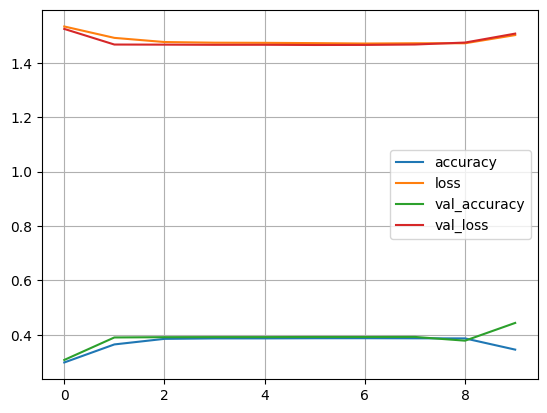

209/209 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step


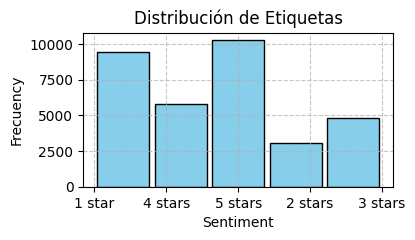

Precisión del modelo: 44.33%
F1-score: 0.32664299592304746


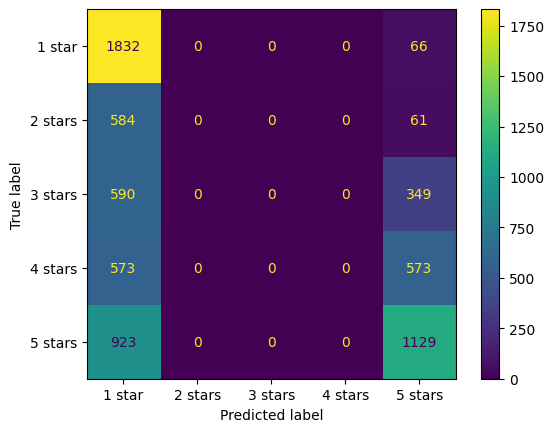

209/209 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step


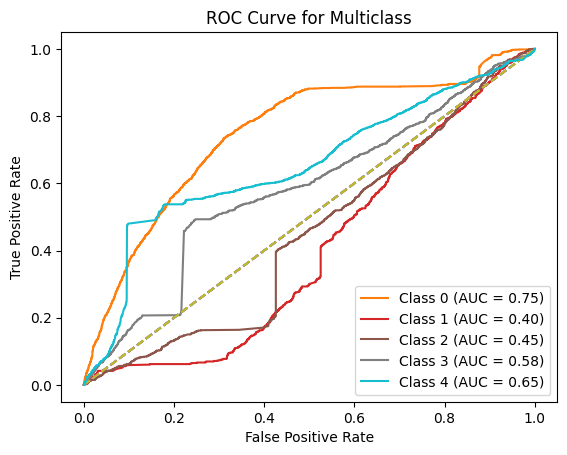

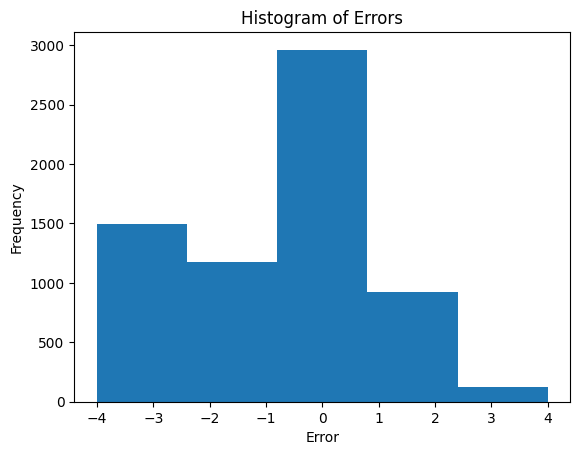

In [ ]:
# Contruir el modelo
model = keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.LSTM(128, return_sequences=True),
    Dropout(0.2),
    keras.layers.LSTM(64, return_sequences=True), # Add return_sequences=True
    Dropout(0.2),
    keras.layers.LSTM(32),
    Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    Dropout(0.2),
    keras.layers.Dense(5, activation='sigmoid'),
   ])

# Compilación del modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # Use categorical_crossentropy for multi-class

# Imprimir el resumen del modelo
model.summary()

num_epochs = 10

# Entrenamiento del modelo
history = model.fit(padded, train_labels, epochs = num_epochs, validation_data = (testing_padded, test_labels))

# Graficar el historial de entrenamiento
pd.DataFrame(history.history).plot(grid=True)
plt.show()

# Genera predicciones para los datos de prueba
predictions = model.predict(testing_padded)
# Convierte las probabilidades en etiquetas (0 o 1)
predicted_labels = np.argmax(predictions, axis=1)

# NO NEED TO CONVERT predicted_labels to one-hot encoding
# predicted_labels_onehot = tf.keras.utils.to_categorical(predicted_labels, num_classes=5)
# Revisar la distribución en un histograma
labels = df['rating'].tolist()
plt.figure(figsize=(4, 2))
plt.hist(labels, color='skyblue', edgecolor='black', rwidth=0.9, bins=5)  # rwidth controla el ancho de las barras
plt.xlabel('Sentiment')
plt.ylabel('Frecuency')
plt.title('Distribución de Etiquetas')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Convert test_labels to class indices
test_labels_indices = np.argmax(test_labels, axis=1)

# Calcula la precisión del modelo
accuracy = np.mean(predicted_labels == test_labels_indices)  # Compare indices of predicted and true labels
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

# Convert test_labels to class indices
test_labels_indices = np.argmax(test_labels, axis=1)

# Use 'weighted' averaging for multiclass F1-score
f1 = f1_score(test_labels_indices, predicted_labels, average='weighted')  # Pass class indices for both true and predicted labels
print(f"F1-score: {f1}")

# Calculate confusion matrix using class indices for both true and predicted labels
cm = confusion_matrix(test_labels_indices, predicted_labels)  # Change here
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['1 star', '2 stars', '3 stars', '4 stars', '5 stars'])
disp.plot()
plt.show()

#sns.heatmap(cm, annot=True, fmt='d')
#plt.xlabel('Predicted')
#plt.ylabel('True')
#plt.show()

# Calculate probabilities for each class
y_pred_proba = model.predict(testing_padded)

# ROC curve for each class
plt.figure()
for i in range(y_pred_proba.shape[1]):  # Assuming one-hot encoded predictions
    fpr, tpr, _ = roc_curve(test_labels_indices == i, y_pred_proba[:, i]) # Use test_labels_indices which contains class indices
    auc = roc_auc_score(test_labels_indices == i, y_pred_proba[:, i]) # Use test_labels_indices which contains class indices
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, label='Class %d (AUC = %0.2f)' % (i, auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass')
plt.legend()
plt.show()


# Convert test_labels to class indices
test_labels_indices = np.argmax(test_labels, axis=1)

# Calculate errors using class indices
errors = predicted_labels - test_labels_indices

plt.hist(errors, bins=5)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Errors')
plt.show()

In [ ]:
# Contruir el modelo
model = keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.LSTM(128, return_sequences=True),
    Dropout(0.2),
    keras.layers.LSTM(64, return_sequences=True),
    Dropout(0.2),
    keras.layers.LSTM(32, return_sequences=False), # Set return_sequences=False for the last LSTM layer
    Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    Dropout(0.2),
    keras.layers.Dense(5, activation='softmax'),
   ])

# Compilación del modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # Use categorical_crossentropy for multi-class

# Imprimir el resumen del modelo
model.summary()

num_epochs = 10

# Entrenamiento del modelo
history = model.fit(padded, train_labels, epochs = num_epochs, validation_data = (testing_padded, test_labels))

# Graficar el historial de entrenamiento
pd.DataFrame(history.history).plot(grid=True)
plt.show()

# Genera predicciones para los datos de prueba
predictions = model.predict(testing_padded)
# Convierte las probabilidades en etiquetas (0 o 1)
predicted_labels = np.argmax(predictions, axis=1)

# NO NEED TO CONVERT predicted_labels to one-hot encoding
# predicted_labels_onehot = tf.keras.utils.to_categorical(predicted_labels, num_classes=5)
# Revisar la distribución en un histograma
labels = df['rating'].tolist()
plt.figure(figsize=(4, 2))
plt.hist(labels, color='skyblue', edgecolor='black', rwidth=0.9, bins=5)  # rwidth controla el ancho de las barras
plt.xlabel('Sentiment')
plt.ylabel('Frecuency')
plt.title('Distribución de Etiquetas')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Convert test_labels to class indices
test_labels_indices = np.argmax(test_labels, axis=1)

# Calcula la precisión del modelo
accuracy = np.mean(predicted_labels == test_labels_indices)  # Compare indices of predicted and true labels
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

# Convert test_labels to class indices
test_labels_indices = np.argmax(test_labels, axis=1)

# Use 'weighted' averaging for multiclass F1-score
f1 = f1_score(test_labels_indices, predicted_labels, average='weighted')  # Pass class indices for both true and predicted labels
print(f"F1-score: {f1}")

# Calculate confusion matrix using class indices for both true and predicted labels
cm = confusion_matrix(test_labels_indices, predicted_labels)  # Change here
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['1 star', '2 stars', '3 stars', '4 stars', '5 stars'])
disp.plot()
plt.show()

#sns.heatmap(cm, annot=True, fmt='d')
#plt.xlabel('Predicted')
#plt.ylabel('True')
#plt.show()

# Calculate probabilities for each class
y_pred_proba = model.predict(testing_padded)

# ROC curve for each class
plt.figure()
for i in range(y_pred_proba.shape[1]):  # Assuming one-hot encoded predictions
    fpr, tpr, _ = roc_curve(test_labels_indices == i, y_pred_proba[:, i]) # Use test_labels_indices which contains class indices
    auc = roc_auc_score(test_labels_indices == i, y_pred_proba[:, i]) # Use test_labels_indices which contains class indices
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, label='Class %d (AUC = %0.2f)' % (i, auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass')
plt.legend()
plt.show()


# Convert test_labels to class indices
test_labels_indices = np.argmax(test_labels, axis=1)

# Calculate errors using class indices
errors = predicted_labels - test_labels_indices

plt.hist(errors, bins=5)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Errors')
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_20 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_22 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 336s 342ms/step - accuracy: 0.2975 - loss: 1.5413 - val_accuracy: 0.4181 - val_loss: 1.4617
Epoch 2/10


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-23-f19a2f0544f6>", line 26, in <cell line: 26>
    history = model.fit(padded, train_labels, epochs = num_epochs, validation_data = (testing_padded, test_labels))
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 317, in fit
    callbacks.on_train_batch_begin(step)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py", line 98, in on_train_batch_begin
    def on_train_batch_begin(self, batch, logs=None):
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.

TypeError: object of type 'NoneType' has no len()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 600s 702ms/step - accuracy: 0.4514 - loss: 1.3253 - val_accuracy: 0.6208 - val_loss: 0.9851
Epoch 2/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 630s 712ms/step - accuracy: 0.6182 - loss: 0.9943 - val_accuracy: 0.6277 - val_loss: 0.9497
Epoch 3/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 617s 706ms/step - accuracy: 0.6407 - loss: 0.9253 - val_accuracy: 0.6478 - val_loss: 0.9006
Epoch 4/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 615s 697ms/step - accuracy: 0.6596 - loss: 0.8748 - val_accuracy: 0.6487 - val_loss: 0.8970
Epoch 5/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 626s 702ms/step - accuracy: 0.6670 - loss: 0.8544 - val_accuracy: 0.6515 - val_loss: 0.8875
Epoch 6/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 610s 688ms/step - accuracy: 0.6720 - loss: 0.8365 - val_accuracy: 0.6506 - val_loss: 0.9073
Epoch 7/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 578s 692ms/step - accuracy: 0.6773 - loss: 0.8200 - val_accuracy: 0.6431 - val_loss: 0.8958
Epoch 8/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 625s 696ms/step - accuracy: 0.6764 -

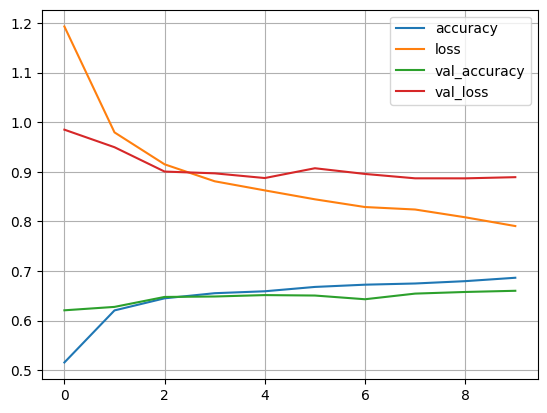

209/209 ━━━━━━━━━━━━━━━━━━━━ 42s 199ms/step


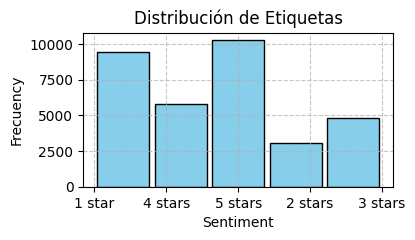

Precisión del modelo: 66.02%
F1-score: 0.6281039898452835


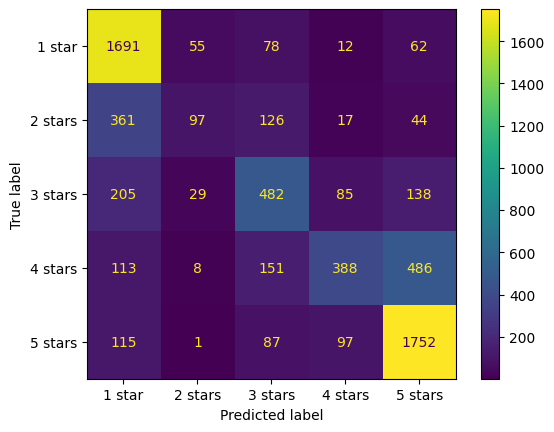

209/209 ━━━━━━━━━━━━━━━━━━━━ 39s 188ms/step


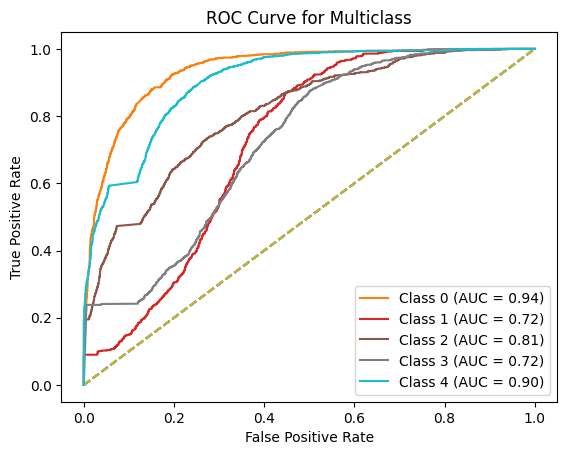

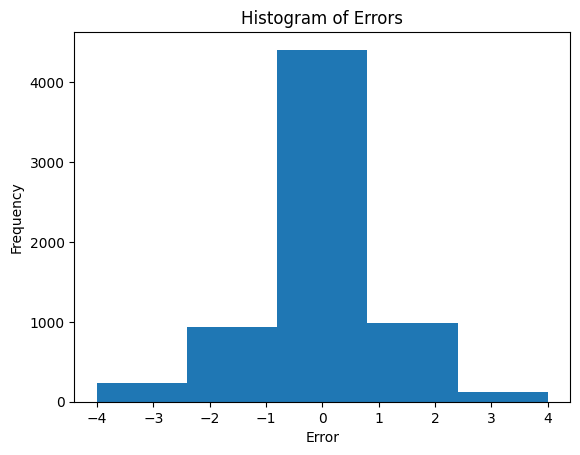

In [ ]:
# Contruir el modelo
model = keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)),
    Dropout(0.2),
    keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True)), # Add return_sequences=True
    Dropout(0.2),
    keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=False)),
    Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    Dropout(0.2),
    keras.layers.Dense(5, activation='sigmoid'),
   ])

# Compilación del modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # Use categorical_crossentropy for multi-class

# Imprimir el resumen del modelo
model.summary()

num_epochs = 10

# Entrenamiento del modelo
history = model.fit(padded, train_labels, epochs = num_epochs, validation_data = (testing_padded, test_labels))

# Graficar el historial de entrenamiento
pd.DataFrame(history.history).plot(grid=True)
plt.show()

# Genera predicciones para los datos de prueba
predictions = model.predict(testing_padded)
# Convierte las probabilidades en etiquetas (0 o 1)
predicted_labels = np.argmax(predictions, axis=1)

# NO NEED TO CONVERT predicted_labels to one-hot encoding
# predicted_labels_onehot = tf.keras.utils.to_categorical(predicted_labels, num_classes=5)
# Revisar la distribución en un histograma
labels = df['rating'].tolist()
plt.figure(figsize=(4, 2))
plt.hist(labels, color='skyblue', edgecolor='black', rwidth=0.9, bins=5)  # rwidth controla el ancho de las barras
plt.xlabel('Sentiment')
plt.ylabel('Frecuency')
plt.title('Distribución de Etiquetas')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Convert test_labels to class indices
test_labels_indices = np.argmax(test_labels, axis=1)

# Calcula la precisión del modelo
accuracy = np.mean(predicted_labels == test_labels_indices)  # Compare indices of predicted and true labels
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

# Convert test_labels to class indices
test_labels_indices = np.argmax(test_labels, axis=1)

# Use 'weighted' averaging for multiclass F1-score
f1 = f1_score(test_labels_indices, predicted_labels, average='weighted')  # Pass class indices for both true and predicted labels
print(f"F1-score: {f1}")

# Calculate confusion matrix using class indices for both true and predicted labels
cm = confusion_matrix(test_labels_indices, predicted_labels)  # Change here
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['1 star', '2 stars', '3 stars', '4 stars', '5 stars'])
disp.plot()
plt.show()

#sns.heatmap(cm, annot=True, fmt='d')
#plt.xlabel('Predicted')
#plt.ylabel('True')
#plt.show()

# Calculate probabilities for each class
y_pred_proba = model.predict(testing_padded)

# ROC curve for each class
plt.figure()
for i in range(y_pred_proba.shape[1]):  # Assuming one-hot encoded predictions
    fpr, tpr, _ = roc_curve(test_labels_indices == i, y_pred_proba[:, i]) # Use test_labels_indices which contains class indices
    auc = roc_auc_score(test_labels_indices == i, y_pred_proba[:, i]) # Use test_labels_indices which contains class indices
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, label='Class %d (AUC = %0.2f)' % (i, auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass')
plt.legend()
plt.show()


# Convert test_labels to class indices
test_labels_indices = np.argmax(test_labels, axis=1)

# Calculate errors using class indices
errors = predicted_labels - test_labels_indices

plt.hist(errors, bins=5)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Errors')
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 668s 785ms/step - accuracy: 0.4795 - loss: 1.2713 - val_accuracy: 0.6052 - val_loss: 0.9642
Epoch 2/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 673s 774ms/step - accuracy: 0.6403 - loss: 0.9106 - val_accuracy: 0.6403 - val_loss: 0.8920
Epoch 3/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 680s 772ms/step - accuracy: 0.6853 - loss: 0.8021 - val_accuracy: 0.6497 - val_loss: 0.8851
Epoch 4/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 683s 774ms/step - accuracy: 0.7143 - loss: 0.7263 - val_accuracy: 0.6645 - val_loss: 0.8968
Epoch 5/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 682s 774ms/step - accuracy: 0.7417 - loss: 0.6618 - val_accuracy: 0.6608 - val_loss: 0.9118
Epoch 6/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 684s 776ms/step - accuracy: 0.7661 - loss: 0.6078 - val_accuracy: 0.6648 - val_loss: 0.9571
Epoch 7/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 651s 780ms/step - accuracy: 0.7864 - loss: 0.5645 - val_accuracy: 0.6639 - val_loss: 1.0008
Epoch 8/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 691s 828ms/step - accuracy: 0.8012 -

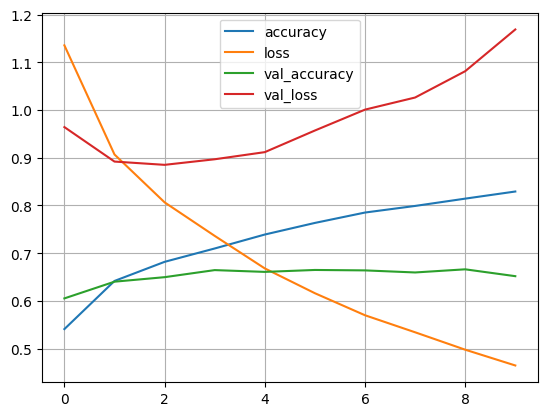

209/209 ━━━━━━━━━━━━━━━━━━━━ 46s 214ms/step


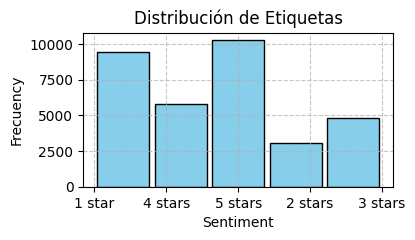

Precisión del modelo: 65.18%
F1-score: 0.6509415384572048


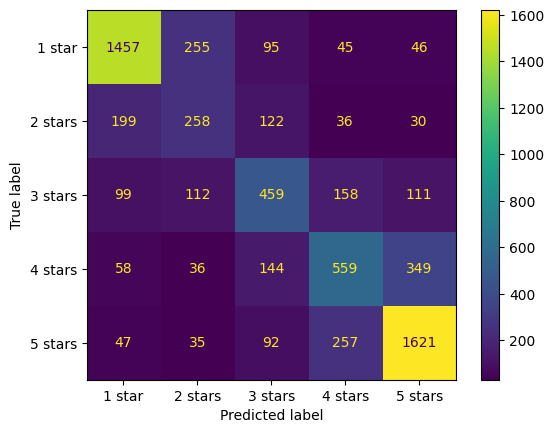

209/209 ━━━━━━━━━━━━━━━━━━━━ 43s 204ms/step


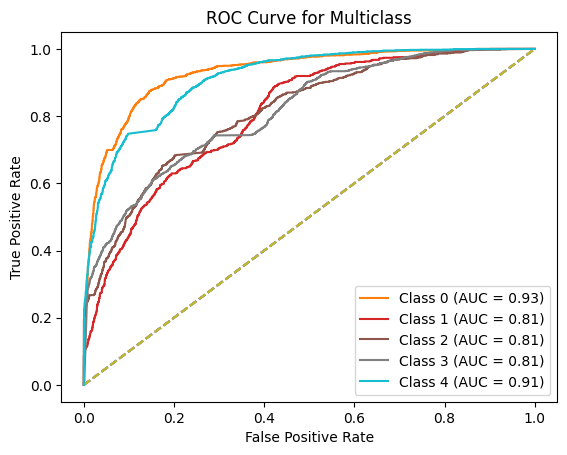

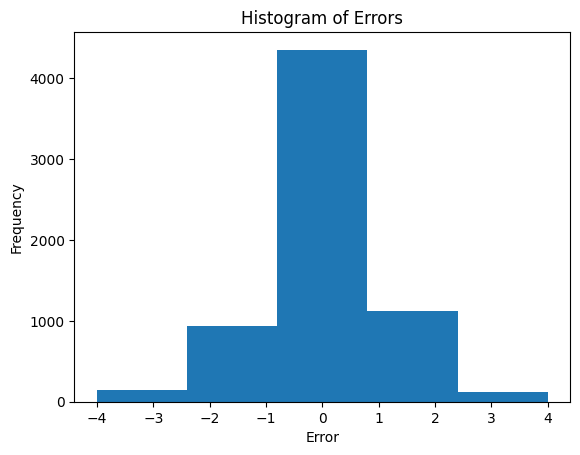

In [ ]:
# Contruir el modelo
model = keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)),
    Dropout(0.2),
    keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True)), # Add return_sequences=True
    Dropout(0.2),
    keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=False)),
    Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    Dropout(0.2),
    keras.layers.Dense(5, activation='sigmoid'),
   ])

# Compilación del modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # Use categorical_crossentropy for multi-class

# Imprimir el resumen del modelo
model.summary()

num_epochs = 10

# Entrenamiento del modelo
history = model.fit(padded, train_labels, epochs = num_epochs, validation_data = (testing_padded, test_labels))

# Graficar el historial de entrenamiento
pd.DataFrame(history.history).plot(grid=True)
plt.show()

# Genera predicciones para los datos de prueba
predictions = model.predict(testing_padded)
# Convierte las probabilidades en etiquetas (0 o 1)
predicted_labels = np.argmax(predictions, axis=1)

# NO NEED TO CONVERT predicted_labels to one-hot encoding
# predicted_labels_onehot = tf.keras.utils.to_categorical(predicted_labels, num_classes=5)
# Revisar la distribución en un histograma
labels = df['rating'].tolist()
plt.figure(figsize=(4, 2))
plt.hist(labels, color='skyblue', edgecolor='black', rwidth=0.9, bins=5)  # rwidth controla el ancho de las barras
plt.xlabel('Sentiment')
plt.ylabel('Frecuency')
plt.title('Distribución de Etiquetas')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Convert test_labels to class indices
test_labels_indices = np.argmax(test_labels, axis=1)

# Calcula la precisión del modelo
accuracy = np.mean(predicted_labels == test_labels_indices)  # Compare indices of predicted and true labels
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

# Convert test_labels to class indices
test_labels_indices = np.argmax(test_labels, axis=1)

# Use 'weighted' averaging for multiclass F1-score
f1 = f1_score(test_labels_indices, predicted_labels, average='weighted')  # Pass class indices for both true and predicted labels
print(f"F1-score: {f1}")

# Calculate confusion matrix using class indices for both true and predicted labels
cm = confusion_matrix(test_labels_indices, predicted_labels)  # Change here
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['1 star', '2 stars', '3 stars', '4 stars', '5 stars'])
disp.plot()
plt.show()

#sns.heatmap(cm, annot=True, fmt='d')
#plt.xlabel('Predicted')
#plt.ylabel('True')
#plt.show()

# Calculate probabilities for each class
y_pred_proba = model.predict(testing_padded)

# ROC curve for each class
plt.figure()
for i in range(y_pred_proba.shape[1]):  # Assuming one-hot encoded predictions
    fpr, tpr, _ = roc_curve(test_labels_indices == i, y_pred_proba[:, i]) # Use test_labels_indices which contains class indices
    auc = roc_auc_score(test_labels_indices == i, y_pred_proba[:, i]) # Use test_labels_indices which contains class indices
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, label='Class %d (AUC = %0.2f)' % (i, auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass')
plt.legend()
plt.show()


# Convert test_labels to class indices
test_labels_indices = np.argmax(test_labels, axis=1)

# Calculate errors using class indices
errors = predicted_labels - test_labels_indices

plt.hist(errors, bins=5)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Errors')
plt.show()